# Multivariate Gaussian Random Walk

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

import pymc3 as pm
import theano

%matplotlib inline

Simulate the data:

In [168]:
np.random.seed(42)

D = 2
N = 150
sections = 3

period = N/sections

Sigma_a = np.random.randn(D, D)
Sigma_a = Sigma_a.T.dot(Sigma_a)
L_a = cholesky(Sigma_a, lower=True)

Sigma_b = np.random.randn(D, D)
Sigma_b = Sigma_b.T.dot(Sigma_b)
L_b = cholesky(Sigma_b, lower=True)

# Gaussian Random walk:
alpha = np.cumsum(L_a.dot(np.random.randn(D, sections)), axis=1).T
beta = np.cumsum(L_b.dot(np.random.randn(D, sections)), axis=1).T
sigma = 1

t = np.arange(N)[:, None]/ N
alpha = np.repeat(alpha, period, axis=0)
beta = np.repeat(beta, period, axis=0)
y_true = alpha + beta*t
y = alpha + beta*t + sigma*np.random.randn(N, 1)

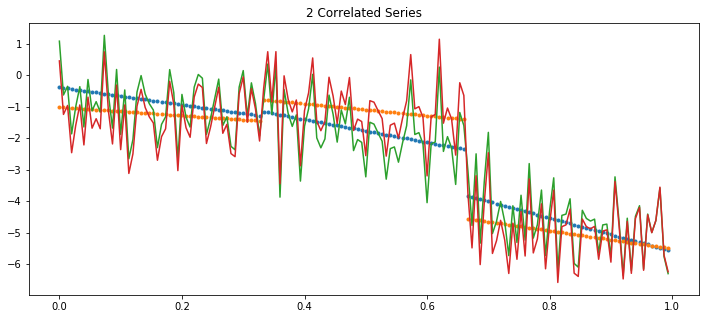

In [169]:
plt.figure(figsize=(12, 5))
plt.plot(t, y_true, '.')
plt.plot(t, y)
plt.title(f'{D} Correlated Series');

In [134]:
class Scaler():
    def __init__(self):
        mean_ = None
        std_ = None
    
    def transform(self, x):
        return (x - self.mean_) / self.std_
    
    def fit_transform(self, x):
        self.mean_ = x.mean(axis=0)
        self.std_ = x.std(axis=0)
        return self.transform(x)
    
    def inverse_transform(self, x):
        return x*self.std_ + self.mean_

In [135]:
# Standardies y and t
y_scaler = Scaler()
t_scaler = Scaler()

y_scaled = y_scaler.fit_transform(y)
t_scaled = t_scaler.fit_transform(t)

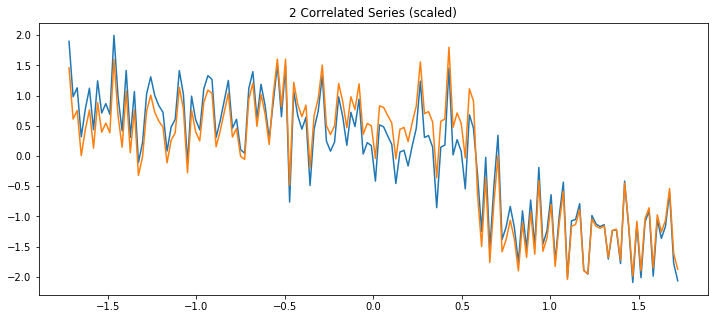

In [136]:
plt.figure(figsize=(12, 5))
plt.plot(t_scaled, y_scaled)
plt.title(f'{D} Correlated Series (scaled)');

In [137]:
with pm.Model() as model:
    packed_L_alpha = pm.LKJCholeskyCov('packed_L_alpha', n=D,   
                             eta=2., sd_dist=pm.HalfNormal.dist(1))
    L_alpha = pm.expand_packed_triangular(D, packed_L_alpha)

    packed_L_beta = pm.LKJCholeskyCov('packed_L_beta', n=D,   
                             eta=2., sd_dist=pm.HalfNormal.dist(1))
    L_beta = pm.expand_packed_triangular(D, packed_L_beta)

    alpha = pm.MvGaussianRandomWalk('alpha', shape=(N, D), chol=L_alpha)
    
    beta = pm.MvGaussianRandomWalk('beta', shape=(N, D), chol=L_beta)

    regression = alpha + beta * t_scaled

    sd = pm.HalfNormal('sd', sigma=10)
    
    likelihood = pm.Normal('likelihood', mu=regression, sigma=sd, observed=y_scaled)
    trace = pm.sample(draws=2000, tune=2000, cores=1)


C:\Miniconda3\envs\test_package\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
C:\Miniconda3\envs\test_package\lib\site-packages\theano\tensor\subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


alpha __str__ = [150   2]
regression __str__ = [150   2]
y_scaled (150, 2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Miniconda3\envs\test_package\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sequential sampling (2 chains in 1 job)
NUTS: [sd, beta, alpha, packed_L_beta, packed_L_alpha]
 64%|█████████████████████████████████████████████████▋                            | 2545/4000 [32:34<24:10,  1.00it/s]
The acceptance probability does not match the target. It is 0.5684528166129613, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some conv

GridSpec(1, 1)

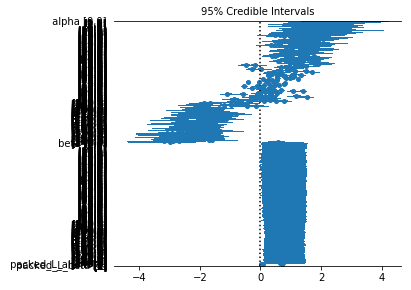

In [138]:
pm.forestplot(trace)

Predict the mean expected y value.

In [139]:
y_pred_scaled = trace['alpha'][-1000:] + t_scaled[None] * trace['beta'][-1000:]
y_pred_scaled.shape

(545, 150, 2)

In [140]:
trace['alpha'][-1000:, :, 0].shape

(545, 150)

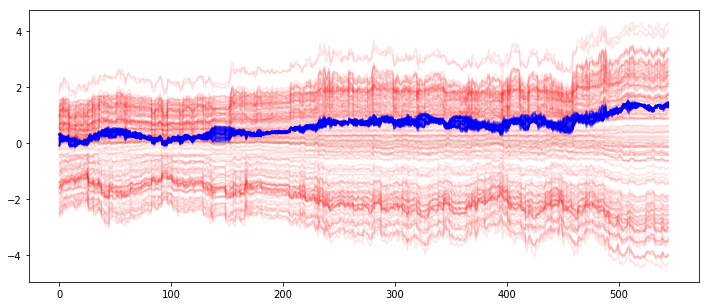

In [141]:
plt.figure(figsize=(12, 5))
plt.plot(trace['alpha'][-1000:, :, 0], ls='-', color='red', alpha=0.1);
plt.plot(trace['beta'][-1000:, :, 0], ls='-', color='blue', alpha=0.1);
plt.plot(trace['sd'][-1000:], ls='-', color='green', alpha=0.1);


In [142]:
a_mean = trace['alpha'][-1000:].mean(axis=0)
b_mean = trace['beta'][-1000:].mean(axis=0)

a_mean.shape

(150, 2)

In [143]:
y_mean_pred_scaled = a_mean + t_scaled * b_mean
y_mean_pred_scaled.shape

(150, 2)

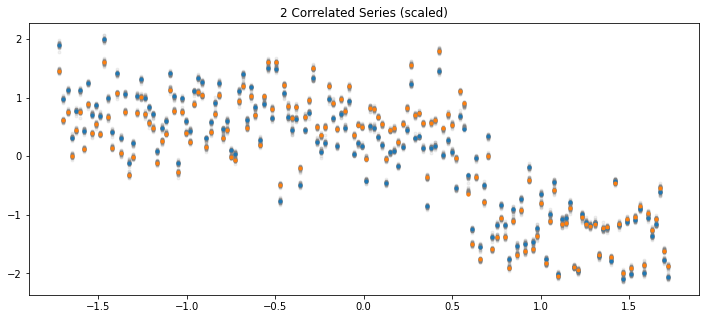

In [147]:
plt.figure(figsize=(12, 5))

for alpha, beta, sd in zip(trace['alpha'][-1000::10, :, :], 
                          trace['beta'][-1000::10, :, :], 
                          trace['sd'][-1000::10]):
    mu = alpha + t_scaled[None] * beta
    y_random = np.random.normal(loc=mu[0, :, :], scale=sd)
    
    plt.plot(t_scaled, y_random, '.', color='gray', alpha=0.1)

plt.plot(t_scaled, y_scaled, '.')

plt.title(f'{D} Correlated Series (scaled)');

In [149]:
with model:
    ppc = pm.sample_posterior_predictive(trace)

100%|███████████████████████████████████████████████████████████████████████████████| 545/545 [00:02<00:00, 225.22it/s]


In [152]:
ppc['likelihood'].shape

(545, 150, 2)

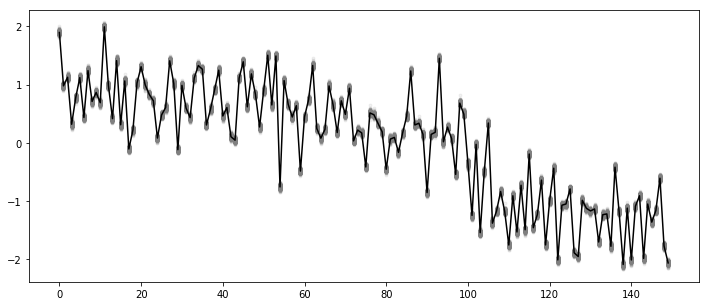

In [166]:
plt.figure(figsize=(12, 5))
plt.plot(ppc['y'][:, :, 0].T, '.', color='gray', alpha=0.1);
plt.plot(y_mean_pred_scaled[:, 0], '-k')